In [42]:
import gym
import random
import import_ipynb
import proj_env
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import json
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

    

In [43]:
def create_env(seed):
    random.seed(seed)

    the_n_env = proj_env.GridWorldEnv(render_mode='rgb_array')
    the_n_env.reset(seed = seed)
    return the_n_env

In [44]:
the_n_env = create_env(0)
down = np.array([1,0])
up = np.array([-1,0])
right = np.array([0,1])
left = np.array([0,-1])

action_to_direction = {1: right,2: left,3: down,4: up}


food_list = ["RedApple", "RedOnions", "YellowOnions", "Bread", "YellowCheese", "WhiteCheese",
         "RedBellPepper", "GreenBellPepper", "GreenApple", "YellowEgg", "WhiteEgg", "Butter",
         "Ham", "RedMeat", "WhiteMeat", "Salt", "Herbs"]

tools_list =[ "Pot", "Oven", "Knife", "MixingBowl"]

guest_list = ["Red","White","Green","Yellow"]

original_loc = the_n_env._Agent_location
plate_loc = the_n_env._Plate_location

size = the_n_env.size
print(size)



15


In [45]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/iy1616/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [46]:
def show_env(env):
    image_array = the_n_env._render_frame()

    plt.figure(figsize=(20, 20))
    # Display the image array
    plt.imshow(image_array)
    plt.axis('off')  # Hide the axis
    plt.show()


2000


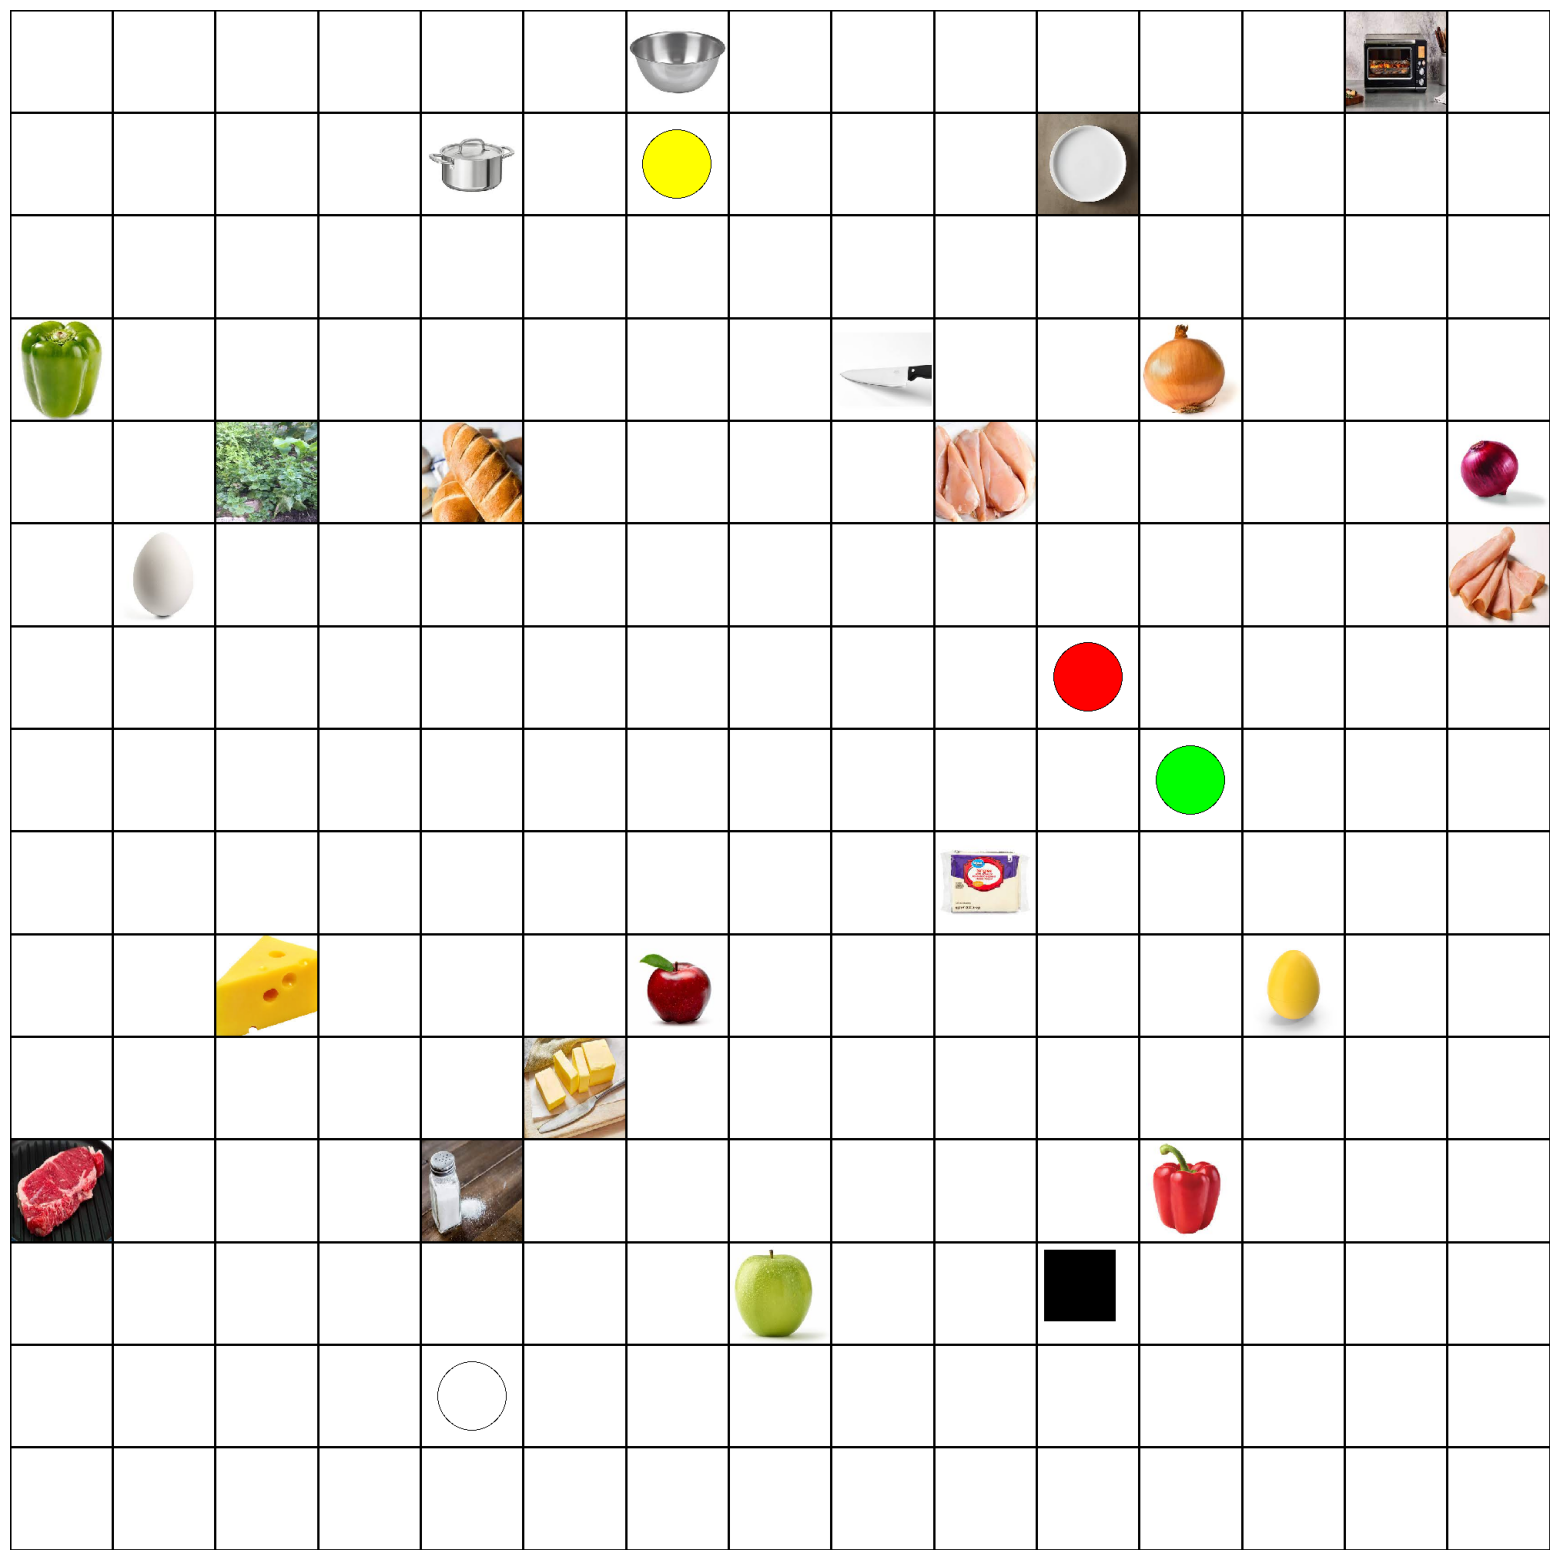

In [47]:
show_env(the_n_env)

In [48]:
def movingList(distance):
    
    x = distance[0]
    y = distance[1]
    lst = []
    a_lst = []
    if x < 0:
        for i in range(x,0):
            lst.append(1)
            a_lst.append("Right")
    elif x > 0:
        for i in range(x):
            lst.append(2)
            a_lst.append("Left")
    if y < 0:
        for i in range(y,0):
            lst.append(3)
            a_lst.append("Down")
    elif y > 0:
        for i in range(y):
            lst.append(4)
            a_lst.append("Up")

    return lst, a_lst

In [49]:
diff_loc = dict()
act_loc = dict()
for f in food_list:
    loc = getattr(the_n_env, "_"+f + "_location")
    distance = original_loc - loc
    x = distance[0]
    y = distance[1]
    lst,a_lst = movingList(distance)
    diff_loc[f] = lst
    act_loc[f] = a_lst

    distance_p = plate_loc - loc
    lst,a_lst = movingList(distance_p)
    o_lst , oa_lst = movingList(-distance_p)
    k = "Plate-"+f
    diff_loc[k] = lst
    act_loc[k] = a_lst

    k = f+"-Plate"
    diff_loc[k] = o_lst
    act_loc[k] = oa_lst

    for t in tools_list:
        t_loc = getattr(the_n_env, "_"+t + "_location")
        distance = original_loc - t_loc
        lst,a_lst = movingList(distance)
        diff_loc[t] = lst
        act_loc[t] = a_lst  
        
        distance = loc - t_loc
        lst,a_lst = movingList(distance)
        k = f+"-"+t
        diff_loc[k] = lst
        act_loc[k] = a_lst

        lst,a_lst = movingList(-distance)
        k = t+"-"+f
        diff_loc[k] = lst
        act_loc[k] = a_lst

        distance_p = t_loc - plate_loc
        lst,a_lst = movingList(distance_p)
        o_lst , oa_lst = movingList(-distance_p)
        k = t+"-Plate"
        diff_loc[k] = lst
        act_loc[k] = a_lst

        k = "Plate-"+t
        diff_loc[k] = o_lst
        act_loc[k] = oa_lst

        for g in guest_list:
            g_loc = getattr(the_n_env, "_"+g + "_location")
            distance = t_loc - g_loc
            lst,a_lst = movingList(distance)
            k = t+"-"+g
            diff_loc[k] = lst
            act_loc[k] = a_lst

            distance_p = plate_loc - g_loc
            lst,a_lst = movingList(distance_p)
            k = "Plate-"+g
            diff_loc[k] = lst
            act_loc[k] = a_lst

        for others_t in tools_list:
            if others_t!=t:
                other_loc = getattr(the_n_env, "_"+others_t + "_location")
                distance = t_loc - other_loc
                lst,a_lst = movingList(distance)
                k = t+"-"+others_t
                diff_loc[k] = lst
                act_loc[k] = a_lst

                lst,a_lst = movingList(-distance)
                k = others_t+"-"+t
                diff_loc[k] = lst
                act_loc[k] = a_lst
        
    for other in food_list:
        if other!=f:
            other_loc = getattr(the_n_env, "_"+other + "_location")
            distance = loc - other_loc
            lst,a_lst = movingList(distance)
            k = f+"-"+other
            diff_loc[k] = lst
            act_loc[k] = a_lst

            lst,a_lst = movingList(-distance)
            k = other+"-"+f
            diff_loc[k] = lst
            act_loc[k] = a_lst


diff_loc["Plate-Plate"] = []


In [50]:
def check_diff(diff_loc = diff_loc, k = None):
    for the_k in diff_loc.keys():
        if k in the_k:
            print(the_k)
            print(diff_loc[the_k])

In [51]:
def get_vocab(f_name):
    info = dict()
    with open(f_name,"r") as f:
        d = json.load(f)
        for i in d["dataset"]:
            e = i["key"]
            if e not in info.keys():
                v = i["value"]
                n_v = set()
                for value in v:
                    n_v.add(tuple(value))
                info[e] = n_v
            else:
                value = info[e]
                v = i["value"]
                n_v = set()
                for elements in v:
                    n_v.add(tuple(elements))
                n_v = value.union(n_v)
                info[e] = n_v

    return info

#info key is command, value is set with multiple solutions and each solution type is tuple



In [52]:
def commandAnalysis(step):
    command = step.split(" ")[0]
    t = step.split(" ")[-1]
    target = ""
    target += t[0].upper()
    target += t[1:].lower()
    if target == "Onion":
        target = step.split(" ")[-2]+"Onions"
    elif target == "Apple" or target == "Egg" or target == "Meat" or target == "Cheese":
        target = step.split(" ")[-2]+target
    elif target == "Pepper":
        target = step.split(" ")[-3]+"Bell"+target
    elif target == "Bowl":
        target = "Mixing"+target
    elif target == "(turkey)":
        target = "WhiteMeat"
    elif target == "(beef)":
        target = "RedMeat"
    else:
        target = target
    
    return command, target



In [53]:
def get_action(info,diff_loc):
    optimal_action = dict()
    for key in info.keys():
        value = info[key]
        big_v = []
        for v in value:
            small_v = []
            last_pos = original_loc
            last_reach = None
            for step in v:
                command, target = commandAnalysis(step)
                if command == "Go":
                    if last_reach == None:
                        small_v += diff_loc[target]
                        last_reach = target
                    else:
                        small_v += diff_loc[last_reach+"-"+target]
                        last_reach = target
                elif command == "Take":
                    small_v.append(5)
                
                elif command == "Prepare":
                    small_v.append(6)

                elif command == "Place":
                    k = last_reach+"-"+"Plate"
                    small_v += diff_loc[k]
                    small_v.append(6)
                    last_reach = "Plate"

                elif command == "Serve":
                    k = last_reach+"-"+target
                    small_v += diff_loc[k]
                    small_v.append(7)
                    last_reach = None
            big_v.append(small_v)
        optimal_action[key] = big_v
    return optimal_action




In [54]:
info = get_vocab("699_recipe_data.json")
optimal_action = get_action(info,diff_loc)



In [55]:
def make_words_tokenize(optimal_action):
    tokenized = [word_tokenize(text.lower()) for text in optimal_action.keys()]

    all_tokens = [token for text in tokenized  for token in text]
    vocab = Counter(all_tokens)

    word_to_index = {word: i + 1 for i, (word, _) in enumerate(vocab.items())}
    word_to_index["<unk>"] = len(word_to_index) + 1
    # print(word_to_index)

    tokenized_texts_indices = [[word_to_index[token] for token in text] for text in tokenized]

    # Define a maximum sequence length
    max_length = max(len(text) for text in tokenized_texts_indices)

    # Pad sequences with zeros
    padded_sequences = [text + [0] * (20 - len(text)) for text in tokenized_texts_indices]

    return padded_sequences, word_to_index, max_length




In [56]:
def get_test_tokeinize(test_action, my_dictionary):
    
    b_lst = []
    for text in test_action.keys():
        tokenized = word_tokenize(text.lower())
        lst = []
        for w in tokenized:
            if w in my_dictionary.keys():
                lst.append(my_dictionary[w])
            else:
                lst.append(my_dictionary["<unk>"])
        if len(lst)<20:
            lst += [0]*(20-len(lst))

        b_lst.append(lst)
    return b_lst

In [57]:
def make_action_tensor(optimal_action, word_to_index, max_length):
    opt_short_action = []
    for k in optimal_action.keys():
        v = optimal_action[k]

        if len(v) > 1:
            first = len(v[0])
            second = len(v[1])
            if first < second:
                opt_short_action.append(v[0])
            else:
                opt_short_action.append(v[1])
        else:
            opt_short_action.append(v[0])

    # print(opt_short_action)


    max_l =  max(len(act) for act in opt_short_action)


    padded_act = [act + [0] * (max_l - len(act)) for act in opt_short_action]
    return padded_act,max_l


In [58]:
padded_sequences, word_to_index, max_length = make_words_tokenize(optimal_action)
padded_act,max_l = make_action_tensor(optimal_action, word_to_index, max_length)

In [59]:
obs_lst = []
for f in food_list:
    obs_lst.append(getattr(the_n_env, "_"+f + "_location"))
for t in tools_list:
    obs_lst.append(getattr(the_n_env, "_"+t + "_location"))
for g in guest_list:
    obs_lst.append(getattr(the_n_env, "_"+g + "_location"))
obs_lst.append(the_n_env._Agent_location)
obs_lst.append(the_n_env._Plate_location)
obs_lst = torch.tensor(np.array(obs_lst)).float()

obs_mean = torch.mean(obs_lst, dim=0)  # Mean (2 values)
obs_std = torch.std(obs_lst, dim=0)  # Standard deviation (2 values)
obs_summary = torch.cat((obs_mean, obs_std))  # Summary vector (4 values)
print(obs_summary.shape)
print(obs_summary)

torch.Size([4])
tensor([7.1481, 6.1481, 4.2490, 4.0922])


In [60]:
print(len(padded_act))
print(len(padded_sequences))

28
28


In [61]:
class BehaviorCloningModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes=8):
        super(BehaviorCloningModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_classes, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM

        out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)


        # Decode the hidden state of the last time step
        out = self.fc(out)  # out: tensor of shape (batch_size, seq_length, num_classes)

        return out



In [62]:
vocab_size = len(word_to_index) + 1  # Assuming word_to_index is your vocabulary index
embedding_dim = 128  # Example value
hidden_dim = 256  # Example value
num_actions = 8  # Assuming 7 different actions + 1 for padding

In [63]:
def training(batch_size,lr,epoch,obs_info):
    info = get_vocab("699_recipe_data.json")
    optimal_action = get_action(info,diff_loc)
    padded_sequences, word_to_index, max_length = make_words_tokenize(optimal_action)
    padded_act,max_l = make_action_tensor(optimal_action, word_to_index, max_length)
    dataset = TensorDataset(torch.tensor(padded_sequences), torch.tensor(padded_act))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.HuberLoss()
    model = BehaviorCloningModel2(20+obs_info.shape[0], hidden_dim, max_l)
    optimizer = optim.Adam(model.parameters(), lr)
    
    num_epochs = epoch  # Example value

    # model.train()
    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")
    for epoch in pbar:
        for input_batch, target_batch in dataloader:  # Assuming dataloader is your data loader
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            n = input_batch.shape[0]
            obs_summary_repeated = obs_info.repeat(n, 1)
            input_batch = torch.cat((input_batch.float(), obs_summary_repeated), dim=1)
            outputs = model(input_batch.float())
            loss = criterion(outputs.float(), target_batch.float())

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
        pbar.set_postfix(Loss=loss,The_epoch=epoch+1)
    return model,max_l

In [64]:
class BehaviorCloningModel2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_actions):
        super(BehaviorCloningModel2, self).__init__()
        
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_actions)



    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)


        return x

In [72]:
def get_correct_dict(env,optimal_action):

    for i in optimal_action:
        if (i-1)>=0 and (i-1)<=6:
            env.step(i-1)
        else:
            print(i-1)
            break
    return env.get_food_on()

def testing(f_name,env,theModel,word_to_index,obs_info,action_limited,diff_loc=diff_loc):
    info = get_vocab(f_name)
    optimal_action = get_action(info,diff_loc)

    padded_sequences = get_test_tokeinize(optimal_action,word_to_index)

    padded_act, _ = make_action_tensor(optimal_action, word_to_index, action_limited)
    
    x = torch.tensor(padded_sequences)
    y = torch.tensor(padded_act)
    dataset = TensorDataset(x, y)
    batch_size = 1  # You can adjust this according to your needs

    dataloader = DataLoader(dataset, batch_size=batch_size)
    for input_batch, target_batch in dataloader:
        n = input_batch.shape[0]
        obs_summary_repeated = obs_info.repeat(n, 1)
        input_batch = torch.cat((input_batch.float(), obs_summary_repeated), dim=1)
        result = theModel(input_batch.float())
        diff_total = 0
        action_sum = 0
        action_total = 0
        predict_command = []
        opt_command = []
        for i in range(len(target_batch[0])):
            if target_batch[0][i]!=0:
                diff = abs(result[0][i]-target_batch[0][i])
                diff_total += diff
                action_sum += target_batch[0][i]
                action_total += 1
                r = result[0][i]
                opt_command.append(int(target_batch[0][i]))
                if r>0 and r <8:
                    if int(r) == 0:
                        predict_command.append(1)
                    else:
                        a = abs(r-int(r))
                        if a>0.5:
                            predict_command.append(int(r)+1)
                        else:
                            predict_command.append(int(r))
                            
                    

            else:
                break
        print(diff_total/action_sum)
        print(diff_total/action_total)
        print(opt_command)
        print(predict_command)
        copy_env = create_env(0)
        opt_bag = get_correct_dict(env,opt_command)
        pre_bag = get_correct_dict(copy_env,predict_command)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(opt_bag)
        print(pre_bag)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("+++++++++++++++++++++++++++++")
        # print(result)
        # print(target_batch)

    


In [73]:
# model,action_limited = training(10,0.01,10000,obs_info= obs_summary)
testing("699_recipe_test_1.json",the_n_env,model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",the_n_env,model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

tensor(0.5272, grad_fn=<DivBackward0>)
tensor(1.7064, grad_fn=<DivBackward0>)
[2, 2, 2, 5, 2, 4, 4, 4, 5, 1, 1, 4, 4, 4, 4, 4, 4, 6, 2, 2, 4, 4, 4, 6, 1, 1, 1, 1, 3, 6, 1, 3, 3, 3, 3, 3, 3, 7]
[2, 3, 3, 6, 2, 5, 5, 5, 4, 2, 5, 6, 7, 7, 6, 3, 3, 5, 4, 5, 6, 1, 2, 3, 6, 4, 8, 3, 2, 3, 1]
7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'RedApple': ['Knife', 'MixingBowl', 'Plate', 'MixingBowl', 'MixingBowl', 'Plate', 'MixingBowl', 'Oven', 'Plate', 'MixingBowl', 'Pot', 'Plate', 'MixingBowl', 'MixingBowl', 'MixingBowl', 'Plate', 'MixingBowl', 'Oven', 'Plate', 'MixingBowl', 'Pot', 'Plate', 'MixingBowl', 'MixingBowl', 'MixingBowl', 'Plate', 'MixingBowl', 'Oven', 'Plate', 'MixingBowl', 'Pot', 'Plate', 'MixingBowl', 'MixingBowl', 'MixingBowl', 'Plate', 'MixingBowl', 'Oven', 'Plate', 'MixingBowl', 'Pot', 'Plate'], 'RedOnions': [], 'YellowOnions': [], 'Bread': ['MixingBowl', 'MixingBowl', 'MixingBowl', 'Plate', 'MixingBowl', 'Oven', 'Plate', 'MixingBowl', 'Pot', 'Plate', 'MixingBowl', 'MixingBowl',

In [ ]:
model,action_limited = training(10,0.0001,10000,obs_info= obs_summary)
testing("699_recipe_test_1.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

Training: 100%|██████████| 10000/10000 [00:37<00:00, 264.48epoch/s, Loss=tensor(9.4034e-05, grad_fn=<HuberLossBackward0>), The_epoch=1e+4]


tensor(0.1803, grad_fn=<DivBackward0>)
tensor(0.5197, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.2091, grad_fn=<DivBackward0>)
tensor(0.5960, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.2516, grad_fn=<DivBackward0>)
tensor(0.7465, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.2110, grad_fn=<DivBackward0>)
tensor(0.5868, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.6694, grad_fn=<DivBackward0>)
tensor(1.9244, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.7924, grad_fn=<DivBackward0>)
tensor(2.0731, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.5992, grad_fn=<DivBackward0>)
tensor(1.6362, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++


In [ ]:
model,action_limited = training(10,0.001,10000,obs_info= obs_summary)
testing("699_recipe_test_1.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

Training: 100%|██████████| 10000/10000 [00:37<00:00, 263.28epoch/s, Loss=tensor(1.1341e-05, grad_fn=<HuberLossBackward0>), The_epoch=1e+4]


tensor(0.2339, grad_fn=<DivBackward0>)
tensor(0.6742, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.2175, grad_fn=<DivBackward0>)
tensor(0.6200, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3848, grad_fn=<DivBackward0>)
tensor(1.1416, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.1844, grad_fn=<DivBackward0>)
tensor(0.5128, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.6576, grad_fn=<DivBackward0>)
tensor(1.8906, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.7644, grad_fn=<DivBackward0>)
tensor(1.9997, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.6373, grad_fn=<DivBackward0>)
tensor(1.7404, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++


In [ ]:
#Lr cannot be too bigger

model,action_limited = training(10,0.1,10000,obs_info= obs_summary)
testing("699_recipe_test_1.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

Training: 100%|██████████| 10000/10000 [00:37<00:00, 268.51epoch/s, Loss=tensor(0.6537, grad_fn=<HuberLossBackward0>), The_epoch=1e+4]


tensor(0.2944, grad_fn=<DivBackward0>)
tensor(0.8487, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3690, grad_fn=<DivBackward0>)
tensor(1.0519, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3190, grad_fn=<DivBackward0>)
tensor(0.9464, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3586, grad_fn=<DivBackward0>)
tensor(0.9973, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.4177, grad_fn=<DivBackward0>)
tensor(1.2008, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.6023, grad_fn=<DivBackward0>)
tensor(1.5757, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.5134, grad_fn=<DivBackward0>)
tensor(1.4021, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++


In [ ]:
model,action_limited = training(10,0.01,7000,obs_info= obs_summary)
testing("699_recipe_test_1.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

Training: 100%|██████████| 7000/7000 [00:26<00:00, 263.99epoch/s, Loss=tensor(0.1092, grad_fn=<HuberLossBackward0>), The_epoch=7000]    


tensor(0.2154, grad_fn=<DivBackward0>)
tensor(0.6210, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.2396, grad_fn=<DivBackward0>)
tensor(0.6831, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.1655, grad_fn=<DivBackward0>)
tensor(0.4910, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.1377, grad_fn=<DivBackward0>)
tensor(0.3829, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.5059, grad_fn=<DivBackward0>)
tensor(1.4544, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.8798, grad_fn=<DivBackward0>)
tensor(2.3017, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.5266, grad_fn=<DivBackward0>)
tensor(1.4381, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++


In [ ]:
model,action_limited = training(10,0.01,15000,obs_info= obs_summary)
testing("699_recipe_test_1.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

Training: 100%|██████████| 15000/15000 [00:57<00:00, 261.20epoch/s, Loss=tensor(0.4996, grad_fn=<HuberLossBackward0>), The_epoch=15000]  


tensor(0.1141, grad_fn=<DivBackward0>)
tensor(0.3291, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.1677, grad_fn=<DivBackward0>)
tensor(0.4780, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3069, grad_fn=<DivBackward0>)
tensor(0.9106, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.2636, grad_fn=<DivBackward0>)
tensor(0.7330, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.4652, grad_fn=<DivBackward0>)
tensor(1.3375, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.6119, grad_fn=<DivBackward0>)
tensor(1.6008, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.5599, grad_fn=<DivBackward0>)
tensor(1.5290, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++


In [ ]:
obs_embed = torch.tensor(obs_lst).float()
obs_summary = obs_embed.flatten()
print(obs_flattened.shape)

torch.Size([54])


/var/folders/ff/l05d4kh92k1cplt20pm7pbb40000gn/T/ipykernel_10512/1940637338.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_embed = torch.tensor(obs_lst).float()


In [ ]:
model,action_limited = training(10,0.01,10000,obs_info= obs_summary)
testing("699_recipe_test_1.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

Training: 100%|██████████| 10000/10000 [00:39<00:00, 250.13epoch/s, Loss=tensor(0.4627, grad_fn=<HuberLossBackward0>), The_epoch=1e+4]


tensor(0.1738, grad_fn=<DivBackward0>)
tensor(0.5010, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3517, grad_fn=<DivBackward0>)
tensor(1.0028, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.1925, grad_fn=<DivBackward0>)
tensor(0.5711, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3657, grad_fn=<DivBackward0>)
tensor(1.0171, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.4439, grad_fn=<DivBackward0>)
tensor(1.2763, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.4243, grad_fn=<DivBackward0>)
tensor(1.1101, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3881, grad_fn=<DivBackward0>)
tensor(1.0599, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++


In [ ]:
model,action_limited = training(10,0.1,10000,obs_info= obs_summary)
testing("699_recipe_test_1.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

Training: 100%|██████████| 10000/10000 [00:41<00:00, 240.35epoch/s, Loss=tensor(0.5745, grad_fn=<HuberLossBackward0>), The_epoch=1e+4]


tensor(0.2895, grad_fn=<DivBackward0>)
tensor(0.8347, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3635, grad_fn=<DivBackward0>)
tensor(1.0364, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3172, grad_fn=<DivBackward0>)
tensor(0.9411, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3668, grad_fn=<DivBackward0>)
tensor(1.0199, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.4259, grad_fn=<DivBackward0>)
tensor(1.2245, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.6008, grad_fn=<DivBackward0>)
tensor(1.5718, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.5071, grad_fn=<DivBackward0>)
tensor(1.3848, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++


In [ ]:
model,action_limited = training(10,0.0001,10000,obs_info= obs_summary)
testing("699_recipe_test_1.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

Training: 100%|██████████| 10000/10000 [00:40<00:00, 245.05epoch/s, Loss=tensor(4.6354e-06, grad_fn=<HuberLossBackward0>), The_epoch=1e+4]


tensor(0.2427, grad_fn=<DivBackward0>)
tensor(0.6996, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.1921, grad_fn=<DivBackward0>)
tensor(0.5477, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.2500, grad_fn=<DivBackward0>)
tensor(0.7417, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.1797, grad_fn=<DivBackward0>)
tensor(0.4999, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.6803, grad_fn=<DivBackward0>)
tensor(1.9558, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.6012, grad_fn=<DivBackward0>)
tensor(1.5728, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.6652, grad_fn=<DivBackward0>)
tensor(1.8165, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++


In [ ]:
model,action_limited = training(10,0.01,5000,obs_info= obs_summary)
testing("699_recipe_test_1.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

Training: 100%|██████████| 5000/5000 [00:20<00:00, 248.79epoch/s, Loss=tensor(0.3565, grad_fn=<HuberLossBackward0>), The_epoch=5000]


tensor(0.2548, grad_fn=<DivBackward0>)
tensor(0.7347, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3430, grad_fn=<DivBackward0>)
tensor(0.9779, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3798, grad_fn=<DivBackward0>)
tensor(1.1266, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3074, grad_fn=<DivBackward0>)
tensor(0.8549, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.5772, grad_fn=<DivBackward0>)
tensor(1.6595, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.4312, grad_fn=<DivBackward0>)
tensor(1.1281, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.4434, grad_fn=<DivBackward0>)
tensor(1.2109, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++


In [ ]:
model,action_limited = training(10,0.01,15000,obs_info= obs_summary)
testing("699_recipe_test_1.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",model,word_to_index,obs_info=obs_summary,action_limited=action_limited)

Training: 100%|██████████| 15000/15000 [01:01<00:00, 245.79epoch/s, Loss=tensor(0.4170, grad_fn=<HuberLossBackward0>), The_epoch=15000]


tensor(0.2505, grad_fn=<DivBackward0>)
tensor(0.7224, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.2910, grad_fn=<DivBackward0>)
tensor(0.8297, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.2908, grad_fn=<DivBackward0>)
tensor(0.8626, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.3226, grad_fn=<DivBackward0>)
tensor(0.8972, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.5882, grad_fn=<DivBackward0>)
tensor(1.6911, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.6444, grad_fn=<DivBackward0>)
tensor(1.6859, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
tensor(0.8010, grad_fn=<DivBackward0>)
tensor(2.1872, grad_fn=<DivBackward0>)
+++++++++++++++++++++++++++++
